# Seleção de Atributos
Objetivo: Avaliar os atributos mais relevantes para o desempenho acadêmico utilizando testes estatísticos e regressões com base nos módulos existentes.

## Importações e Configurações Iniciais

In [187]:
# Permite importar módulos .py que estão na raiz do repositório 

import sys, pathlib
ROOT = pathlib.Path().resolve().parents[1] 
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

In [188]:
#Importação dos módulos desenvolvidos

from pre_modelagem import *
from eda_functions import *
from feature_selection import *

# Bibliotecas

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import seaborn as sns
import matplotlib.pyplot as plt

import warnings

# Ignora todos os warnings
warnings.filterwarnings('ignore')


# 1. Importação da Base e Pré-Modelagem

In [189]:
#Import base

#materia =  'matematica' 
materia = 'portugues'
#cor_paleta = 'verde' 
cor_paleta = 'azul'
df = importar_base(materia)

df_original = df.copy() 

# 2. Síntese dos resultados EDA


 - As notas apresentaram distribuições não normais segundo Shapiro-Wilk
 - Algumas variáveis categóricas demonstraram associação com aprovação
 - Multicolinearidade ainda será avaliada neste notebook


## 3. Avaliação de multicolinearidade
- Análise de VIF e correlação para identificar redundâncias entre as variáveis.

In [190]:
df_pp = preparar_dados(df, columns_to_drop=['aprovacao'])

Removendo colunas: ['aprovacao']
Shape final do DataFrame preparado: (649, 42)


In [191]:
# Remove variáveis-alvo antes da análise de VIF/correlação entre preditores
variaveis_target = ['nota1', 'nota2', 'nota_final']
df_preditores = df_pp.drop(columns=variaveis_target)


print('limiar coeficiente de correlação > 0.6')
resumo, vif_df =  relatorio_multicolinearidade(df_preditores,limite_corr=0.6)
    
display(resumo[resumo['avaliacao'] != 'Sem alerta'])


limiar coeficiente de correlação > 0.6


,variavel_1,variavel_2,correlacao
5,escolaridade_pai,escolaridade_mae,0.647477
189,alcool_fim_semana,alcool_dias_uteis,0.616561
526,profissao_pai_Serviços,profissao_pai_Outra profissão,0.709455


,variavel,vif,Alta correlação com,avaliacao
0,idade,75.700824,—,VIF elevado
15,relacao_familiar,19.645464,—,VIF elevado
2,escolaridade_mae,15.864643,escolaridade_pai,VIF alto + correlação alta
16,tempo_livre,12.357453,—,VIF elevado
17,frequencia_saidas,12.081671,—,VIF elevado
12,interesse_ensino_superior,11.333853,—,VIF elevado
3,escolaridade_pai,11.308704,escolaridade_mae,VIF alto + correlação alta
30,profissao_pai_Outra profissão,10.350741,profissao_pai_Serviços,VIF alto + correlação alta
19,alcool_fim_semana,8.724827,alcool_dias_uteis,VIF alto + correlação alta
5,tempo_estudo,7.879912,—,VIF elevado


In [192]:
variaveis_alta_colineariedade = [
            #'escolaridade_mae',
            'escolaridade_pai',
            'alcool_fim_semana',
            #'alcool_dias_uteis',
            'profissao_pai_Outra profissão',
            'profissao_pai_Serviços'
        ]

In [193]:
corr = df_pp[variaveis_alta_colineariedade + variaveis_target].corr()

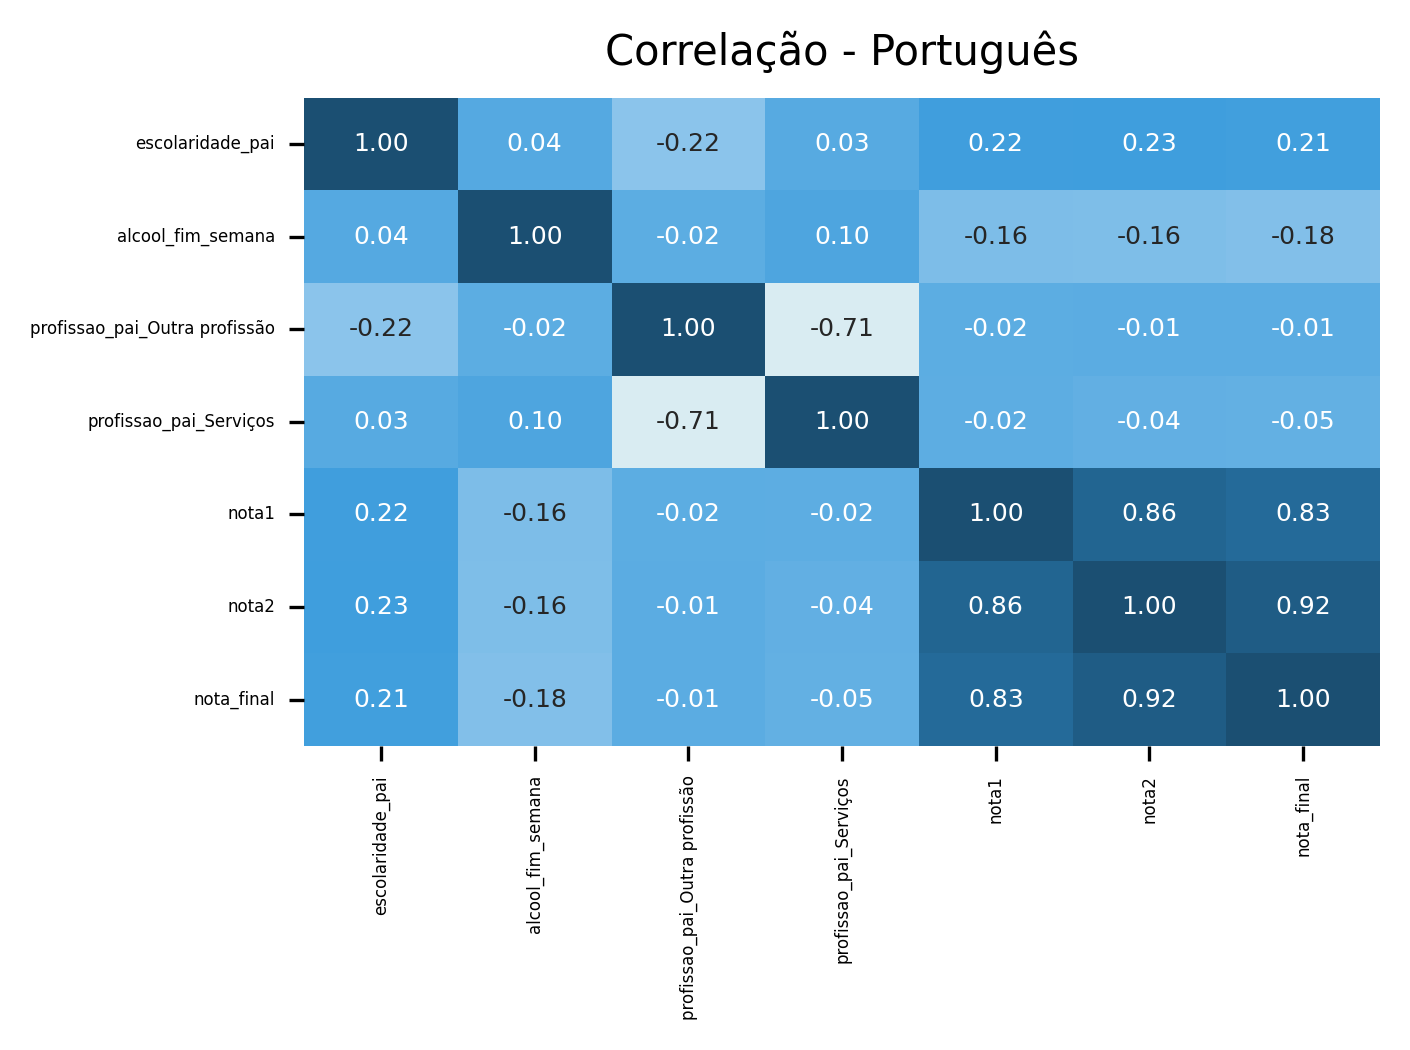

In [194]:
custom_heatmap(disciplina=materia,cores=cor_paleta,matriz_corr=corr, n_arq='corr_multicol',titulo='Correlação')

# 4. Regressão: nota1 -> nota2



## 4.1. Modelo simples (nota1)
- Objetivo: Verificar a relação direta entre nota1 e nota2.
- Avaliar o comportamento dos coeficientes e resíduos.

In [195]:
#Pré processamento

df_pp = preparar_dados(df, columns_to_drop=['aprovacao','nota_final'],target_column='nota2')

Removendo colunas: ['aprovacao', 'nota_final']
Shape final do DataFrame preparado: (649, 41)


                            OLS Regression Results                            
Dep. Variable:                  nota2   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     1922.
Date:                Wed, 07 May 2025   Prob (F-statistic):          6.37e-196
Time:                        22:47:02   Log-Likelihood:                -1166.9
No. Observations:                 649   AIC:                             2338.
Df Residuals:                     647   BIC:                             2347.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1054      0.245      4.503      0.0

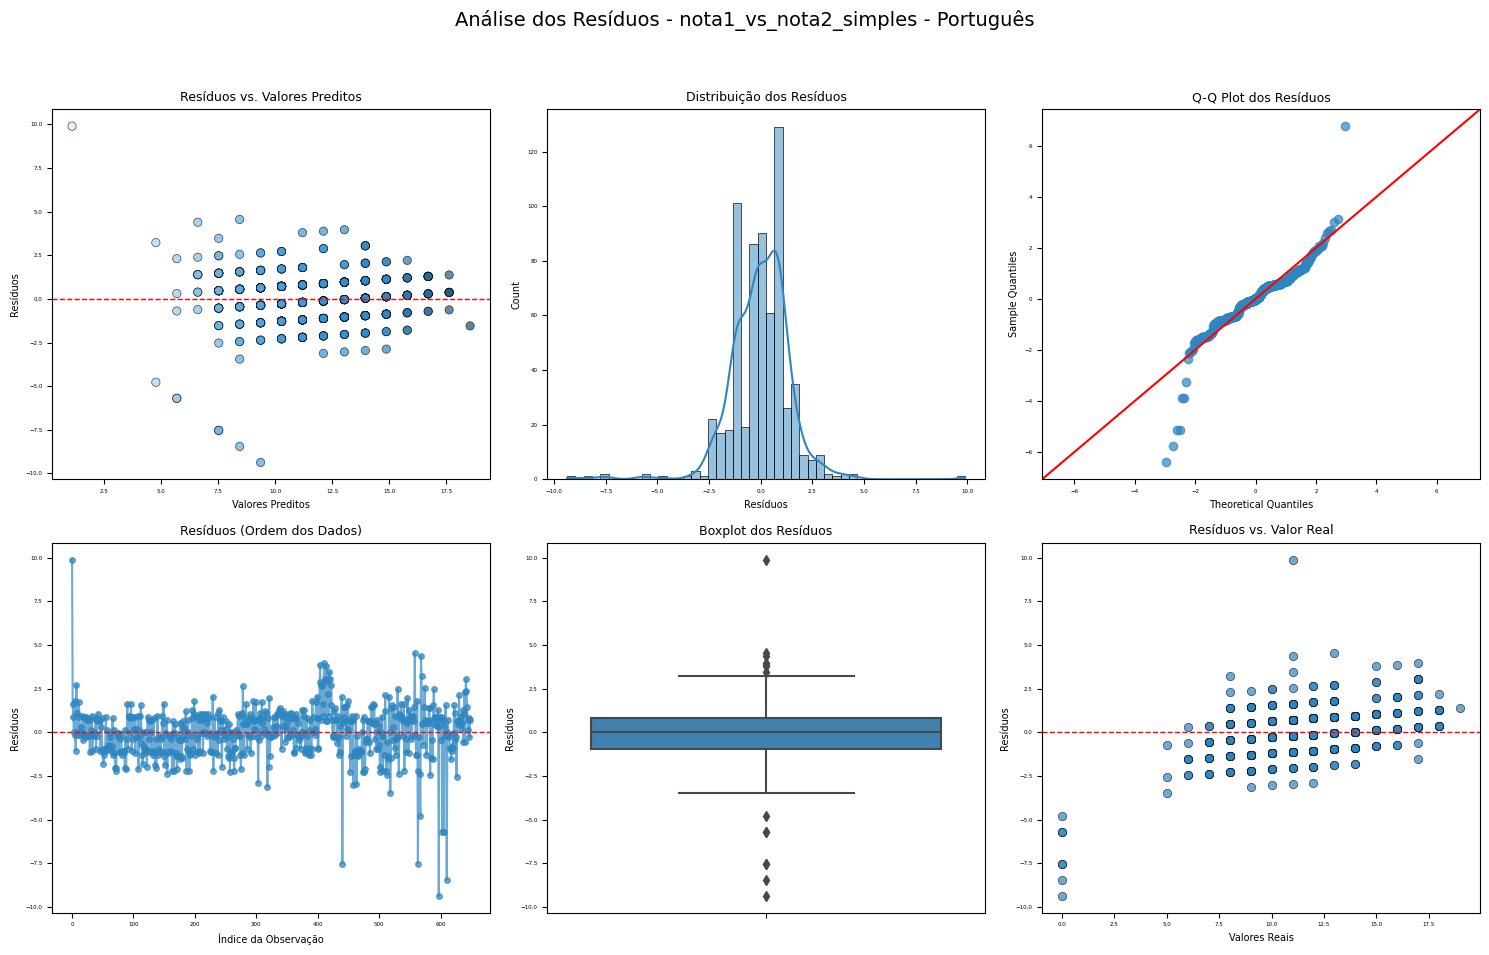

,Média dos Resíduos,Shapiro-Wilk Estatística,Shapiro-Wilk P-valor,Normalidade (Shapiro-Wilk > 0.05),Breusch-Pagan (LM) P-valor,Homoscedasticidade (BP > 0.05),Durbin-Watson Estatística,Autocorrelação (DW ≈ 2),Outliers (|z| > 3)
0,0.0,0.8954,0.0,Não,0.0,Não,1.6694,Ausente (aprox.),10


In [196]:
modelo_m = regressao_multipla(df_pp, target='nota2', variaveis=['nota1'])
print(modelo_m.summary())

_ = avaliar_residuos_regressao(df['nota2'], modelo_m.predict(), 
                           nome_modelo='nota1_vs_nota2_simples', materia=materia)

## 4.2. Regressão múltipla com nota1 e variáveis adicionais
- Objetivo: Avaliar estabilidade dos coeficientes da nota1 e identificar covariáveis explicativas para nota2.

**Regressão sem selecao de atributos**

                            OLS Regression Results                            
Dep. Variable:                  nota2   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     50.27
Date:                Wed, 07 May 2025   Prob (F-statistic):          2.47e-165
Time:                        22:47:03   Log-Likelihood:                -1140.6
No. Observations:                 649   AIC:                             2363.
Df Residuals:                     608   BIC:                             2547.
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

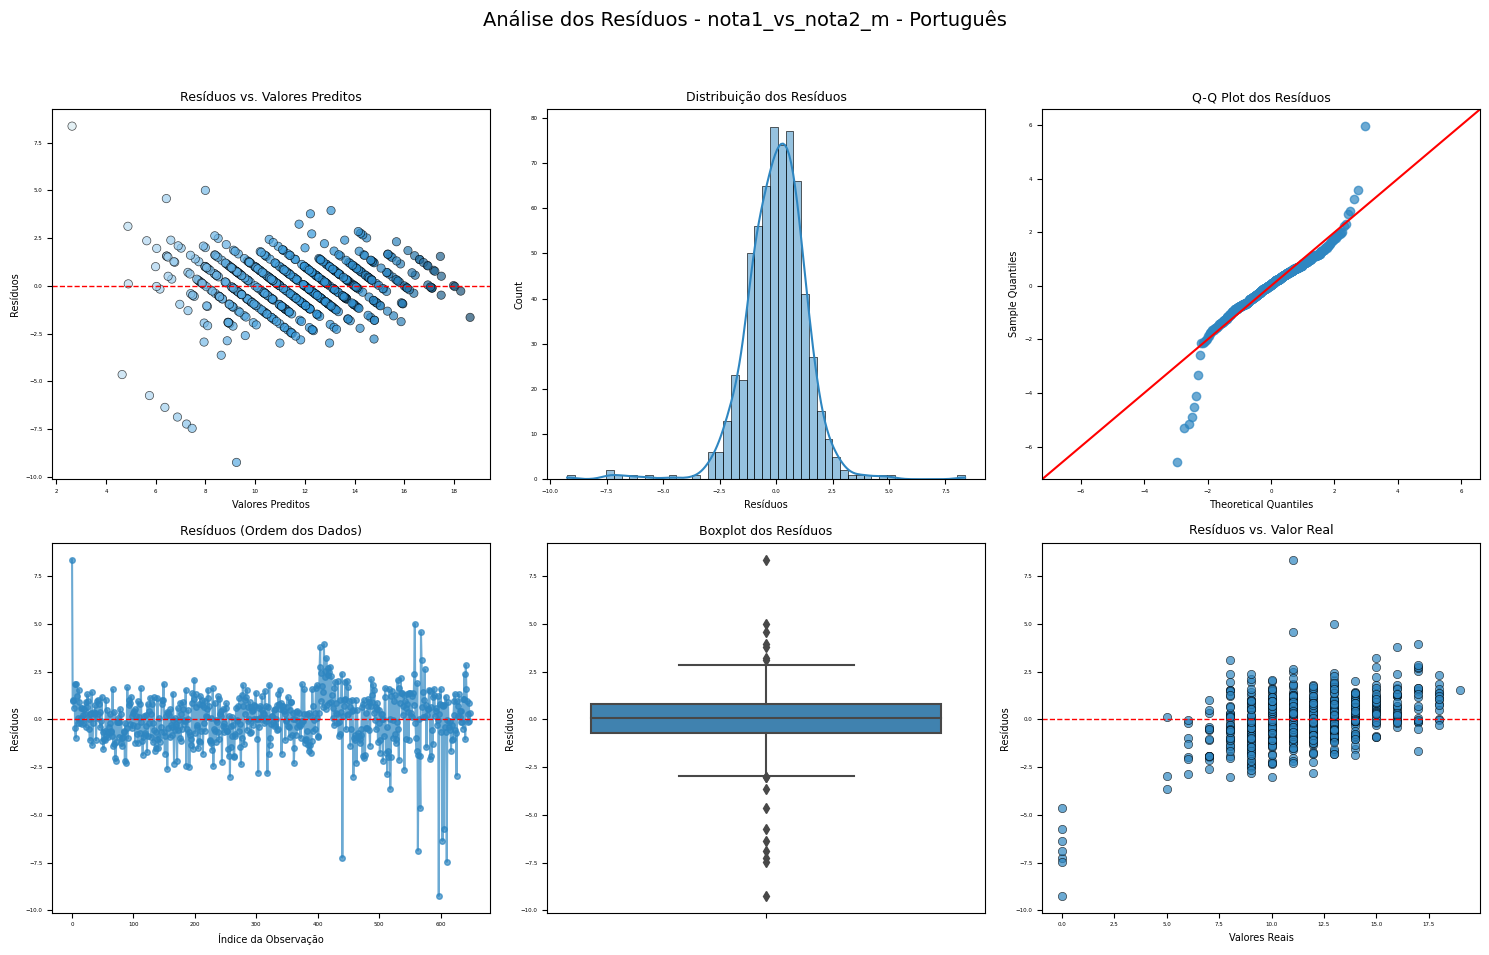

,Média dos Resíduos,Shapiro-Wilk Estatística,Shapiro-Wilk P-valor,Normalidade (Shapiro-Wilk > 0.05),Breusch-Pagan (LM) P-valor,Homoscedasticidade (BP > 0.05),Durbin-Watson Estatística,Autocorrelação (DW ≈ 2),Outliers (|z| > 3)
0,0.0,0.908,0.0,Não,0.0,Não,1.7828,Ausente (aprox.),10


In [197]:
aux_drop = ['nota2']

variaveis_1 = list(set(df_pp.columns) - set(aux_drop))

modelo_m = regressao_multipla(df_pp, target='nota2',variaveis=variaveis_1)
print(modelo_m.summary())

_ =  avaliar_residuos_regressao(df['nota2'], modelo_m.predict(), 
                           nome_modelo='nota1_vs_nota2_m', materia=materia)


**Regressão extraindo atributos com multicolineariedade elevada**

                            OLS Regression Results                            
Dep. Variable:                  nota2   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     55.96
Date:                Wed, 07 May 2025   Prob (F-statistic):          2.45e-168
Time:                        22:47:03   Log-Likelihood:                -1141.8
No. Observations:                 649   AIC:                             2358.
Df Residuals:                     612   BIC:                             2523.
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

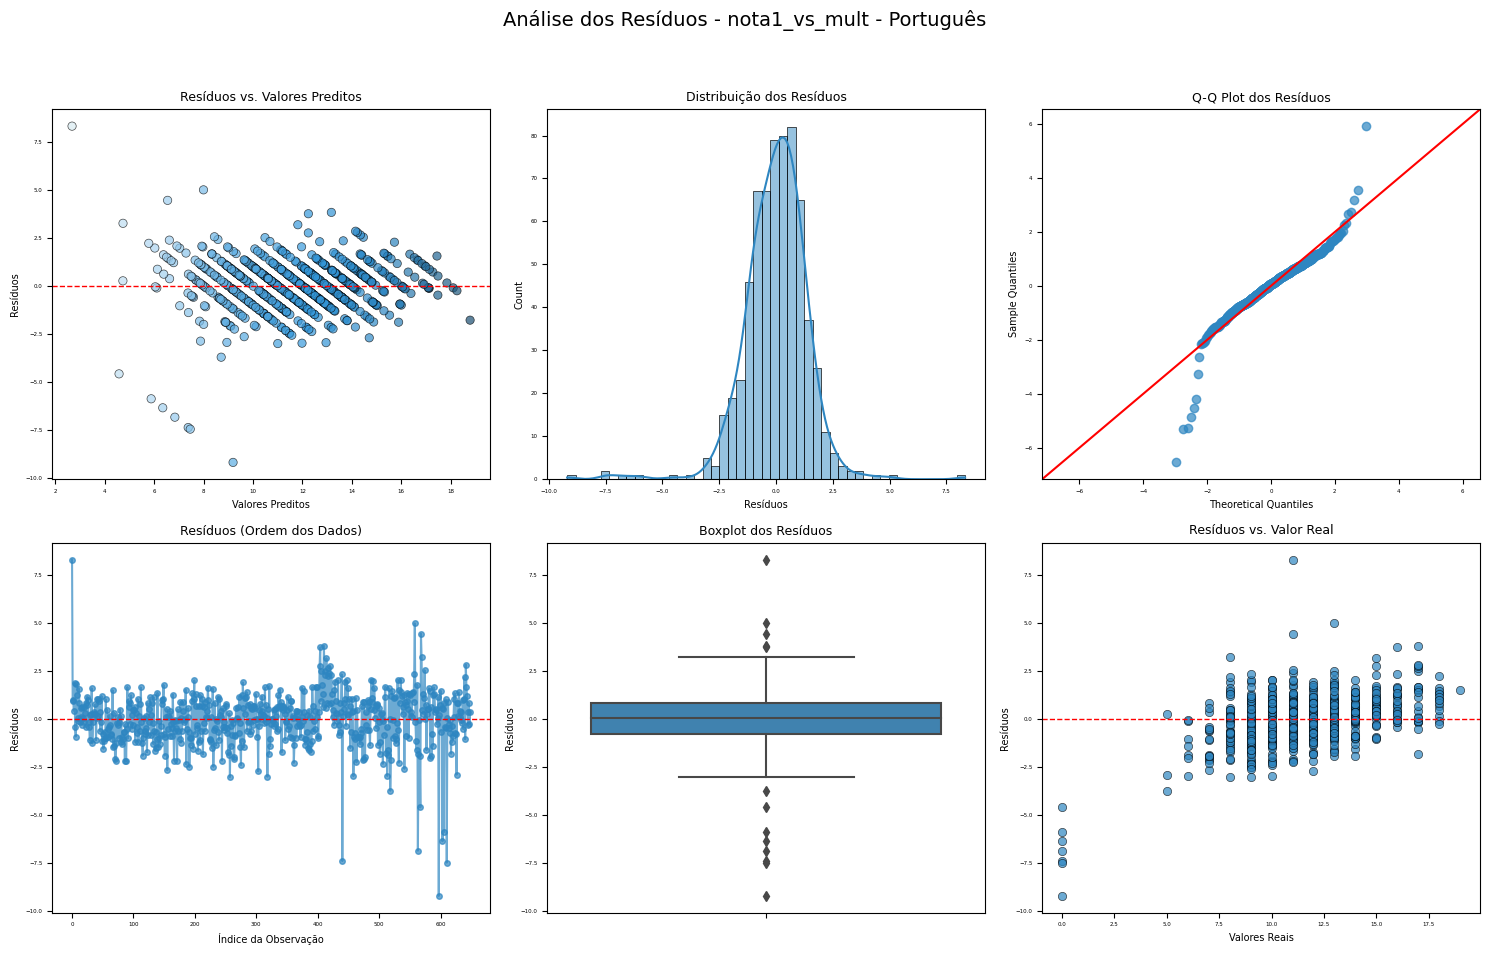

,Média dos Resíduos,Shapiro-Wilk Estatística,Shapiro-Wilk P-valor,Normalidade (Shapiro-Wilk > 0.05),Breusch-Pagan (LM) P-valor,Homoscedasticidade (BP > 0.05),Durbin-Watson Estatística,Autocorrelação (DW ≈ 2),Outliers (|z| > 3)
0,0.0,0.909,0.0,Não,0.0,Não,1.7649,Ausente (aprox.),10


,Média dos Resíduos,Shapiro-Wilk Estatística,Shapiro-Wilk P-valor,Normalidade (Shapiro-Wilk > 0.05),Breusch-Pagan (LM) P-valor,Homoscedasticidade (BP > 0.05),Durbin-Watson Estatística,Autocorrelação (DW ≈ 2),Outliers (|z| > 3)
0,0.0,0.909,0.0,Não,0.0,Não,1.7649,Ausente (aprox.),10


In [198]:
aux_drop = ['nota2']

variaveis_mac = list(set(df_pp.columns) - set(variaveis_alta_colineariedade) - set(aux_drop))

modelo_m = regressao_multipla(df_pp,
                               target='nota2', variaveis=variaveis_mac)

print(modelo_m.summary())

avaliar_residuos_regressao(df['nota2'], modelo_m.predict(), nome_modelo='nota1_vs_mult', materia=materia)



In [199]:
resultados = selecionar_atributos_results_regressao(
        resultados=modelo_m,
        top_n=15)


--- Atributos Mais Relevantes (por P-valor) ---


,Coef.,Std.Err.,t,P>|t|
nota1,0.866,0.026,33.368,7.23e-140
idade,0.192,0.055,3.459,0.001
reprovacoes,-0.369,0.114,-3.254,0.001
relacao_familiar,0.159,0.062,2.560,0.011
relacionamento_romantico,-0.259,0.124,-2.079,0.038
saude,-0.085,0.041,-2.049,0.041
profissao_pai_Professor(a),0.340,0.270,1.259,0.208
interesse_ensino_superior,0.251,0.211,1.190,0.235
frequencia_saidas,-0.065,0.055,-1.175,0.241
escolaridade_mae,0.077,0.071,1.092,0.275


-----------------------------------------------


In [200]:
variaveis_sem_nota = df_pp.drop(columns='nota2').columns

features_bic = stepwise_selection(
    df=df_pp,
    target='nota2',
    variaveis_candidatas=variaveis_sem_nota,
    criterion='aic', 
    verbose=True 
)

features_aic = stepwise_selection(
    df=df_pp,
    target='nota2',
    variaveis_candidatas=variaveis_sem_nota,
    criterion='aic', # Escolhendo BIC
    verbose=True 
)


from itertools import chain

seen = set()
features_all = []    
for item in chain(*[features_aic,features_bic,resultados,variaveis_mac]):
    if item not in seen:
        seen.add(item)
        features_all.append(item)

features_all

Critério inicial (AIC): 3230.8661
Adicionada: nota1 (AIC=2337.8346)
Adicionada: reprovacoes (AIC=2331.1390)
Adicionada: idade (AIC=2322.7072)
Adicionada: relacao_familiar (AIC=2319.3893)
Adicionada: saude (AIC=2317.0038)
Adicionada: relacionamento_romantico (AIC=2314.6177)
Adicionada: escolaridade_mae (AIC=2312.5250)
Adicionada: frequencia_saidas (AIC=2312.2812)
Adicionada: profissao_pai_Serviços (AIC=2312.1365)

Variáveis selecionadas final (aic): ['nota1', 'reprovacoes', 'idade', 'relacao_familiar', 'saude', 'relacionamento_romantico', 'escolaridade_mae', 'frequencia_saidas', 'profissao_pai_Serviços']
Critério inicial (AIC): 3230.8661
Adicionada: nota1 (AIC=2337.8346)
Adicionada: reprovacoes (AIC=2331.1390)
Adicionada: idade (AIC=2322.7072)
Adicionada: relacao_familiar (AIC=2319.3893)
Adicionada: saude (AIC=2317.0038)
Adicionada: relacionamento_romantico (AIC=2314.6177)
Adicionada: escolaridade_mae (AIC=2312.5250)
Adicionada: frequencia_saidas (AIC=2312.2812)
Adicionada: profissao_pa

['nota1',
 'reprovacoes',
 'idade',
 'relacao_familiar',
 'saude',
 'relacionamento_romantico',
 'escolaridade_mae',
 'frequencia_saidas',
 'profissao_pai_Serviços',
 'profissao_pai_Professor(a)',
 'interesse_ensino_superior',
 'aulas_particulares',
 'profissao_mae_Professor(a)',
 'motivo_escolha_escola_Outro motivo',
 'profissao_mae_Serviços',
 'endereco_Urbano',
 'atividades_extracurriculares',
 'alcool_dias_uteis',
 'motivo_escolha_escola_Reputação da escola',
 'acesso_internet',
 'apoio_escolar',
 'responsavel_legal_Pai',
 'profissao_pai_Área da saúde',
 'tempo_livre',
 'faltas',
 'genero_Mulher',
 'motivo_escolha_escola_Próximo de casa',
 'profissao_mae_Outra profissão',
 'tempo_estudo',
 'tamanho_familia',
 'profissao_mae_Área da saúde',
 'responsavel_legal_Outro responsável',
 'frequentou_creche',
 'escola_Mousinho da Silveira',
 'tempo_transporte',
 'apoio_familiar',
 'status_parental_Separados']

                            OLS Regression Results                            
Dep. Variable:                  nota2   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     54.51
Date:                Wed, 07 May 2025   Prob (F-statistic):          9.70e-168
Time:                        22:47:05   Log-Likelihood:                -1141.1
No. Observations:                 649   AIC:                             2358.
Df Residuals:                     611   BIC:                             2528.
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

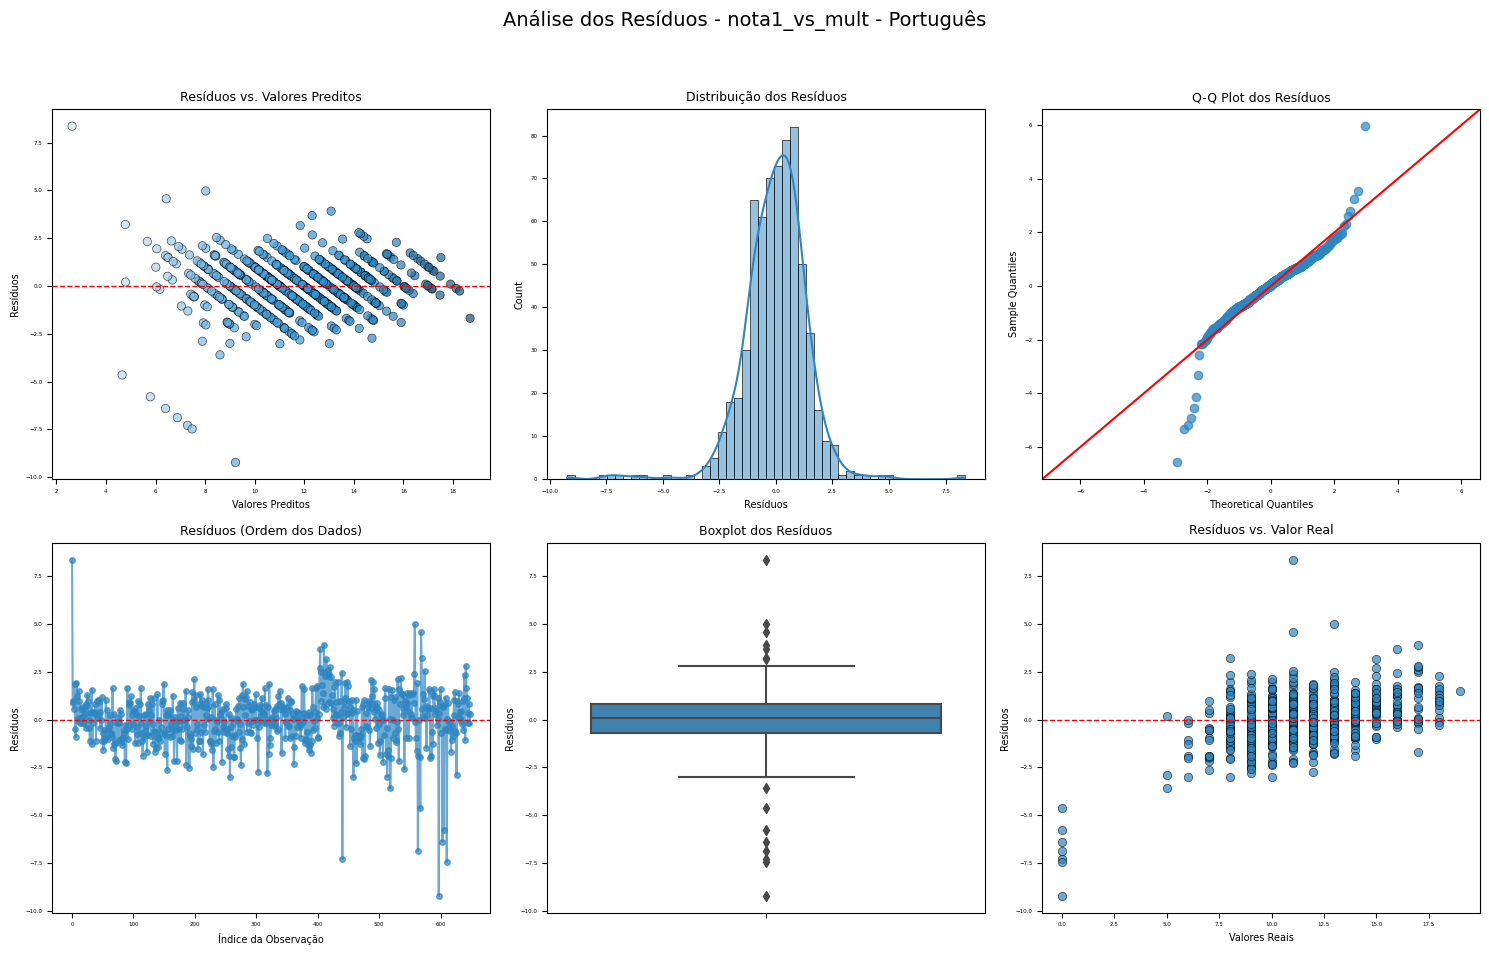

,Média dos Resíduos,Shapiro-Wilk Estatística,Shapiro-Wilk P-valor,Normalidade (Shapiro-Wilk > 0.05),Breusch-Pagan (LM) P-valor,Homoscedasticidade (BP > 0.05),Durbin-Watson Estatística,Autocorrelação (DW ≈ 2),Outliers (|z| > 3)
0,0.0,0.9077,0.0,Não,0.0,Não,1.777,Ausente (aprox.),10


,Média dos Resíduos,Shapiro-Wilk Estatística,Shapiro-Wilk P-valor,Normalidade (Shapiro-Wilk > 0.05),Breusch-Pagan (LM) P-valor,Homoscedasticidade (BP > 0.05),Durbin-Watson Estatística,Autocorrelação (DW ≈ 2),Outliers (|z| > 3)
0,0.0,0.9077,0.0,Não,0.0,Não,1.777,Ausente (aprox.),10


In [201]:
modelo_m = regressao_multipla(df_pp[features_all+['nota2']],target='nota2', variaveis=features_all)

print(modelo_m.summary())

avaliar_residuos_regressao(df['nota2'], modelo_m.predict(), nome_modelo='nota1_vs_mult', materia=materia)

# 5. Regressão com variáveis não relacionadas às notas
- Objetivo: Investigar a contribuição de fatores socioeconômicos e escolares na nota final.

## 5.2 Regressão: variáveis explicativas (sem notas) -> nota_final

In [202]:
df_pp = preparar_dados(df,'nota_final',columns_to_drop=['nota1','nota2','aprovacao'])

Removendo colunas: ['nota1', 'nota2', 'aprovacao']
Shape final do DataFrame preparado: (649, 40)


                            OLS Regression Results                            
Dep. Variable:             nota_final   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     8.797
Date:                Wed, 07 May 2025   Prob (F-statistic):           3.27e-38
Time:                        22:47:06   Log-Likelihood:                -1536.5
No. Observations:                 649   AIC:                             3153.
Df Residuals:                     609   BIC:                             3332.
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

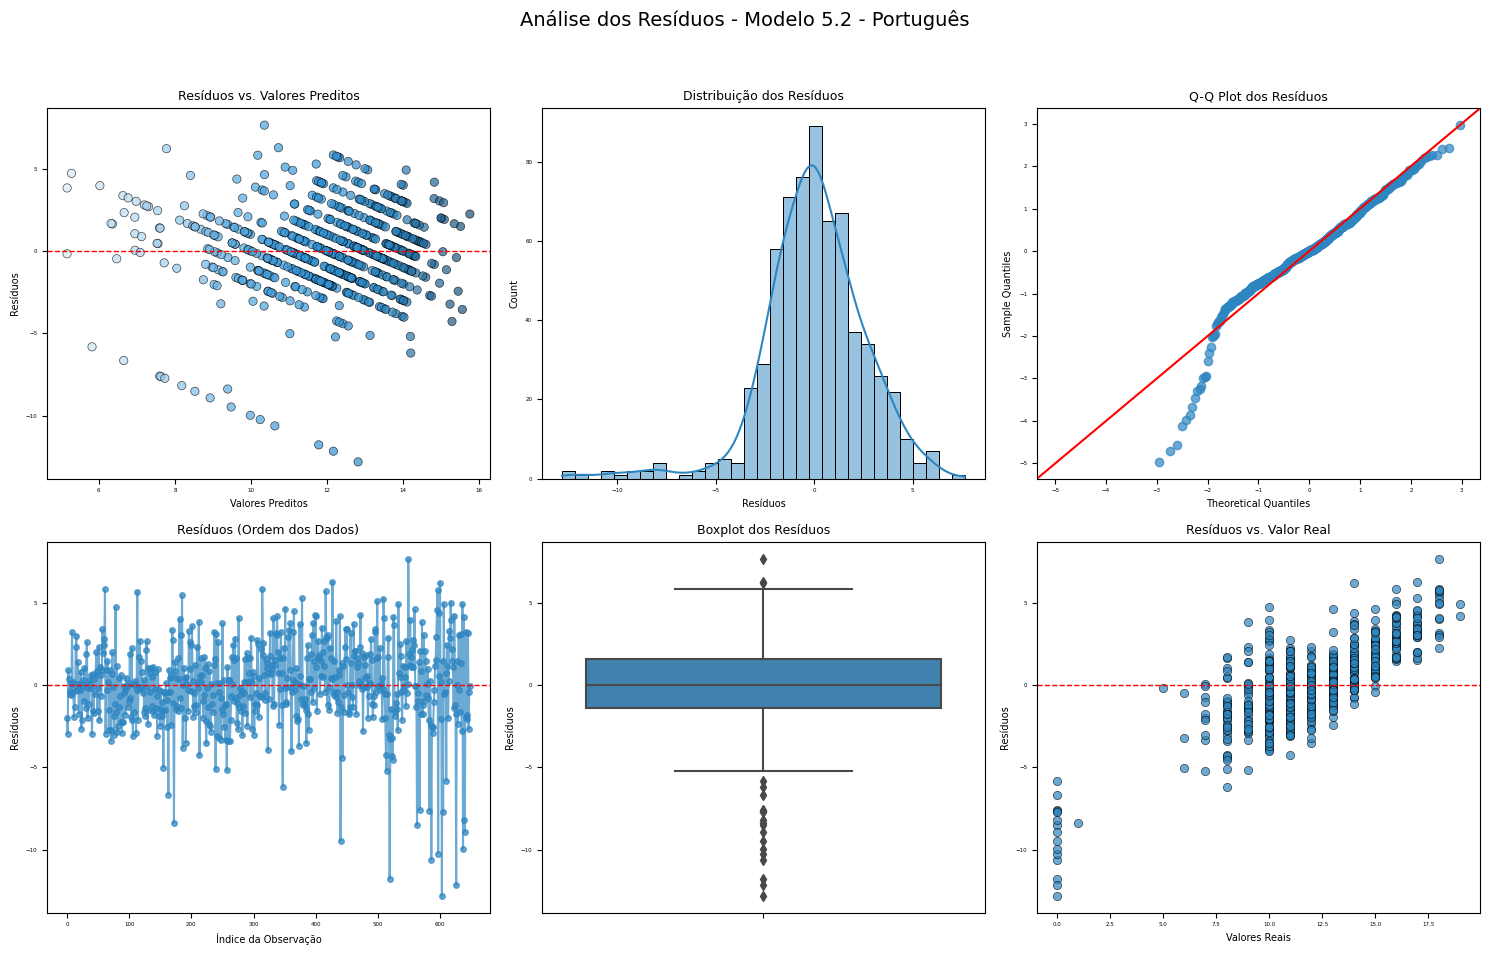

,Média dos Resíduos,Shapiro-Wilk Estatística,Shapiro-Wilk P-valor,Normalidade (Shapiro-Wilk > 0.05),Breusch-Pagan (LM) P-valor,Homoscedasticidade (BP > 0.05),Durbin-Watson Estatística,Autocorrelação (DW ≈ 2),Outliers (|z| > 3)
0,0.0,0.9427,0.0,Não,0.002,Não,1.926,Ausente (aprox.),11


,Média dos Resíduos,Shapiro-Wilk Estatística,Shapiro-Wilk P-valor,Normalidade (Shapiro-Wilk > 0.05),Breusch-Pagan (LM) P-valor,Homoscedasticidade (BP > 0.05),Durbin-Watson Estatística,Autocorrelação (DW ≈ 2),Outliers (|z| > 3)
0,0.0,0.9427,0.0,Não,0.002,Não,1.926,Ausente (aprox.),11


In [203]:
aux_drop = ['nota_final']

variaveis = list(set(df_pp.columns) - set(aux_drop)) 

modelo_m = regressao_multipla(df_pp, target='nota_final', variaveis=variaveis)
print(modelo_m.summary())

avaliar_residuos_regressao(df_vnr['nota_final'], modelo_m.predict(), 
                           nome_modelo='Modelo 5.2', materia=materia)


##### Modelo extraíndo atributos com multicolineariedade

                            OLS Regression Results                            
Dep. Variable:             nota_final   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     9.637
Date:                Wed, 07 May 2025   Prob (F-statistic):           3.63e-39
Time:                        22:47:06   Log-Likelihood:                -1539.2
No. Observations:                 649   AIC:                             3150.
Df Residuals:                     613   BIC:                             3312.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

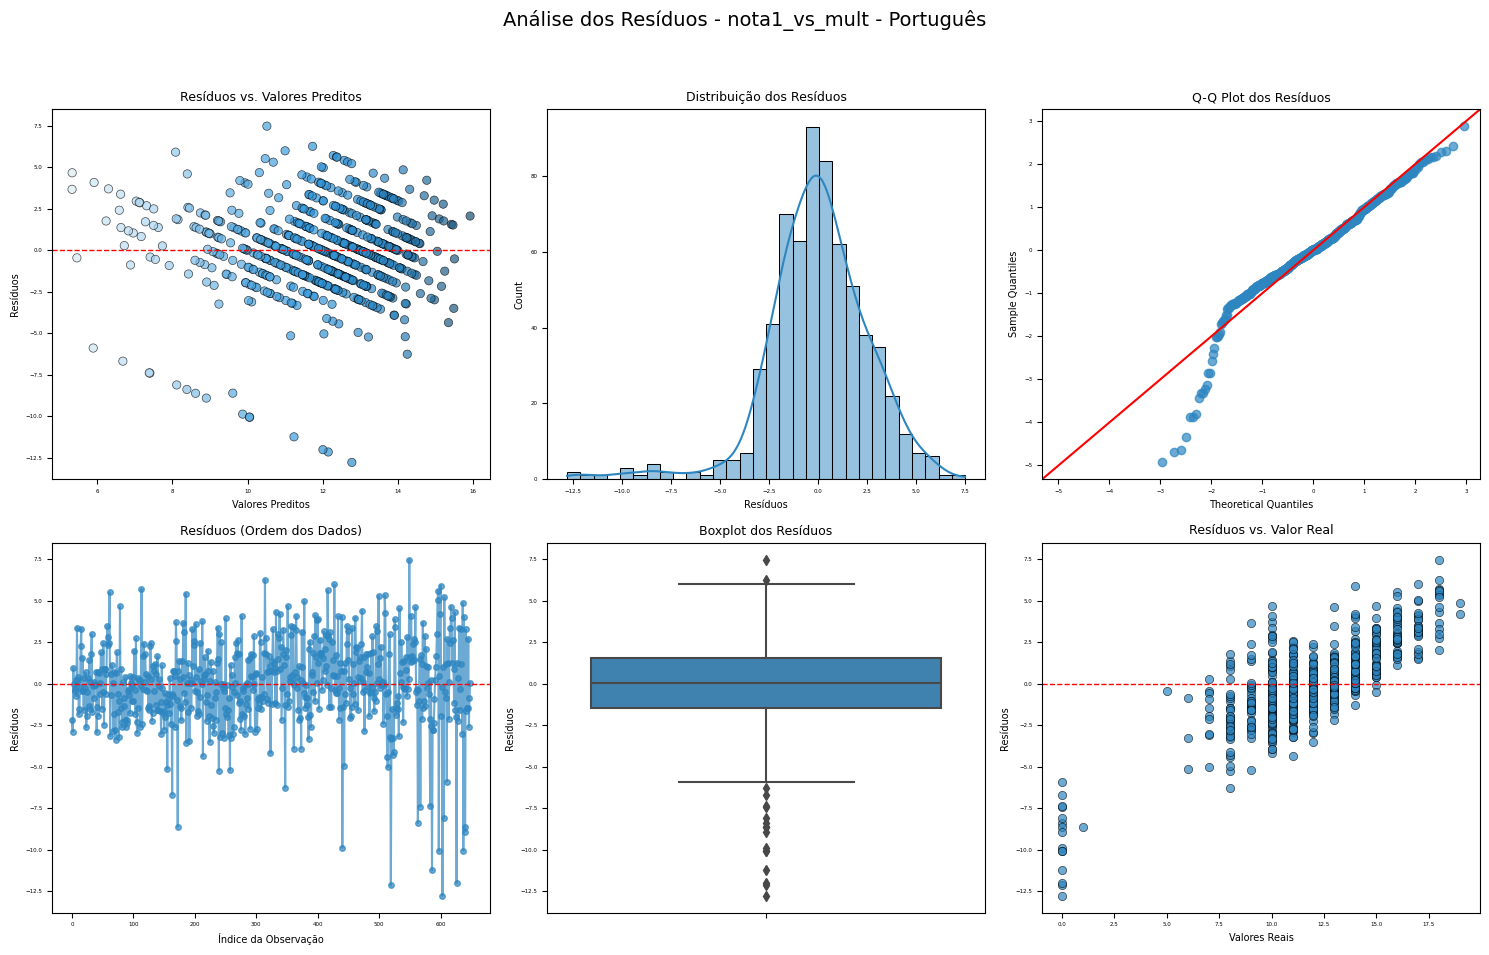

,Média dos Resíduos,Shapiro-Wilk Estatística,Shapiro-Wilk P-valor,Normalidade (Shapiro-Wilk > 0.05),Breusch-Pagan (LM) P-valor,Homoscedasticidade (BP > 0.05),Durbin-Watson Estatística,Autocorrelação (DW ≈ 2),Outliers (|z| > 3)
0,0.0,0.9402,0.0,Não,0.0034,Não,1.9009,Ausente (aprox.),12


,Média dos Resíduos,Shapiro-Wilk Estatística,Shapiro-Wilk P-valor,Normalidade (Shapiro-Wilk > 0.05),Breusch-Pagan (LM) P-valor,Homoscedasticidade (BP > 0.05),Durbin-Watson Estatística,Autocorrelação (DW ≈ 2),Outliers (|z| > 3)
0,0.0,0.9402,0.0,Não,0.0034,Não,1.9009,Ausente (aprox.),12


In [204]:

variaveis = list(set(df_vnr.columns) - set(variaveis_alta_colineariedade) - set(aux_drop))

modelo_m = regressao_multipla(df_vnr,
                               target='nota_final', variaveis=variaveis)

print(modelo_m.summary())

avaliar_residuos_regressao(df_vnr['nota_final'], modelo_m.predict(), 
                           nome_modelo='nota1_vs_mult', materia=materia)




Seleção stepwise (significância estatística)
 - Aplicação do método Stepwise para selecionar variáveis estatisticamente relevantes.
 - Compara-se com o modelo automático de top_n e análise de resíduos.

In [205]:
variaveis_sem_nota = df_vnr.drop(columns='nota_final').columns

In [206]:
features_bic = stepwise_selection(
    df=df_vnr,
    target='nota_final',
    variaveis_candidatas=variaveis_sem_nota,
    criterion='aic', 
    verbose=True 
)

features_aic = stepwise_selection(
    df=df_vnr,
    target='nota_final',
    variaveis_candidatas=variaveis_sem_nota,
    criterion='aic', # Escolhendo BIC
    verbose=True 
)



Critério inicial (AIC): 3364.9269
Adicionada: reprovacoes (AIC=3257.8558)
Adicionada: escola_Mousinho da Silveira (AIC=3213.6149)
Adicionada: interesse_ensino_superior (AIC=3182.9000)
Adicionada: tempo_estudo (AIC=3167.8681)
Adicionada: apoio_escolar (AIC=3156.3992)
Adicionada: alcool_dias_uteis (AIC=3144.4897)
Adicionada: saude (AIC=3139.3444)
Adicionada: escolaridade_pai (AIC=3134.1733)
Adicionada: genero_Mulher (AIC=3131.7602)
Adicionada: profissao_pai_Professor(a) (AIC=3130.4488)
Adicionada: relacionamento_romantico (AIC=3129.2554)
Adicionada: idade (AIC=3128.3966)
Adicionada: profissao_mae_Área da saúde (AIC=3127.3879)
Adicionada: motivo_escolha_escola_Outro motivo (AIC=3126.6716)
Adicionada: faltas (AIC=3126.1230)
Adicionada: acesso_internet (AIC=3125.9093)

Variáveis selecionadas final (aic): ['reprovacoes', 'escola_Mousinho da Silveira', 'interesse_ensino_superior', 'tempo_estudo', 'apoio_escolar', 'alcool_dias_uteis', 'saude', 'escolaridade_pai', 'genero_Mulher', 'profissao_pa

In [207]:
from itertools import chain

seen = set()
features_all = []    
for item in chain(*[features_aic,features_bic]):
    if item not in seen:
        seen.add(item)
        features_all.append(item)

features_all

['reprovacoes',
 'escola_Mousinho da Silveira',
 'interesse_ensino_superior',
 'tempo_estudo',
 'apoio_escolar',
 'alcool_dias_uteis',
 'saude',
 'escolaridade_pai',
 'genero_Mulher',
 'profissao_pai_Professor(a)',
 'relacionamento_romantico',
 'idade',
 'profissao_mae_Área da saúde',
 'motivo_escolha_escola_Outro motivo',
 'faltas',
 'acesso_internet']

In [208]:
features_all


['reprovacoes',
 'escola_Mousinho da Silveira',
 'interesse_ensino_superior',
 'tempo_estudo',
 'apoio_escolar',
 'alcool_dias_uteis',
 'saude',
 'escolaridade_pai',
 'genero_Mulher',
 'profissao_pai_Professor(a)',
 'relacionamento_romantico',
 'idade',
 'profissao_mae_Área da saúde',
 'motivo_escolha_escola_Outro motivo',
 'faltas',
 'acesso_internet']

In [209]:
modelo_m = regressao_multipla(df_vnr,
                               target='nota_final', variaveis=features_all)

print(modelo_m.summary())

                            OLS Regression Results                            
Dep. Variable:             nota_final   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.325
Method:                 Least Squares   F-statistic:                     20.47
Date:                Wed, 07 May 2025   Prob (F-statistic):           1.89e-47
Time:                        22:47:11   Log-Likelihood:                -1546.0
No. Observations:                 649   AIC:                             3126.
Df Residuals:                     632   BIC:                             3202.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

In [210]:
final_selected_vars = features_all

if final_selected_vars: 
    print(f"\nAjustando modelo final com variáveis selecionadas por BIC e AIC: {final_selected_vars}")
    
    
    final_model_results = regressao_multipla(
        df=df_vnr,
        target='nota_final',
        variaveis=final_selected_vars
    )
    print("\n--- Sumário do Modelo Final ---")
    print(final_model_results.summary())
    print("----------------------------")




Ajustando modelo final com variáveis selecionadas por BIC e AIC: ['reprovacoes', 'escola_Mousinho da Silveira', 'interesse_ensino_superior', 'tempo_estudo', 'apoio_escolar', 'alcool_dias_uteis', 'saude', 'escolaridade_pai', 'genero_Mulher', 'profissao_pai_Professor(a)', 'relacionamento_romantico', 'idade', 'profissao_mae_Área da saúde', 'motivo_escolha_escola_Outro motivo', 'faltas', 'acesso_internet']

--- Sumário do Modelo Final ---
                            OLS Regression Results                            
Dep. Variable:             nota_final   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.325
Method:                 Least Squares   F-statistic:                     20.47
Date:                Wed, 07 May 2025   Prob (F-statistic):           1.89e-47
Time:                        22:47:11   Log-Likelihood:                -1546.0
No. Observations:                 649   AIC:                             3126.
Df Resi

In [211]:
print("\nAnálise de significância das variáveis no modelo final:")
selecionar_atributos_results_regressao(
     resultados=final_model_results,
    top_n=len(final_selected_vars) )


Análise de significância das variáveis no modelo final:

--- Atributos Mais Relevantes (por P-valor) ---


,Coef.,Std.Err.,t,P>|t|
reprovacoes,-1.470,0.197,-7.474,2.60e-13
escola_Mousinho da Silveira,-1.360,0.245,-5.542,4.40e-08
interesse_ensino_superior,1.790,0.374,4.782,2.16e-06
apoio_escolar,-1.337,0.357,-3.746,0.0
tempo_estudo,0.451,0.135,3.353,0.001
saude,-0.187,0.073,-2.555,0.011
alcool_dias_uteis,-0.305,0.123,-2.486,0.013
genero_Mulher,0.557,0.234,2.380,0.018
profissao_pai_Professor(a),1.055,0.492,2.142,0.033
relacionamento_romantico,-0.449,0.224,-1.999,0.046


-----------------------------------------------


['reprovacoes',
 'escola_Mousinho da Silveira',
 'interesse_ensino_superior',
 'apoio_escolar',
 'tempo_estudo',
 'saude',
 'alcool_dias_uteis',
 'genero_Mulher',
 'profissao_pai_Professor(a)',
 'relacionamento_romantico',
 'idade',
 'motivo_escolha_escola_Outro motivo',
 'escolaridade_pai',
 'faltas',
 'profissao_mae_Área da saúde',
 'acesso_internet']

# 6. Testes estatísticos para seleção de atributos

In [212]:
variaveis_categoricas_nominais = [
    'escola', 
    'genero', 
    'endereco', 
    'status_parental', 
    'profissao_mae', 
    'profissao_pai', 
    'motivo_escolha_escola', 
    'responsavel_legal', 
    'apoio_escolar', 
    'apoio_familiar', 
    'aulas_particulares', 
    'atividades_extracurriculares', 
    'frequentou_creche', 
    'interesse_ensino_superior', 
    'acesso_internet', 
    'relacionamento_romantico',
    'tamanho_familia',

    ]

variaveis_categoricas_ordinais = [
    'escolaridade_mae', 
    'escolaridade_pai', 
    'relacao_familiar',
    'tempo_livre',      
    'frequencia_saidas',
    'saude',            
    'tempo_estudo',     
    'tempo_transporte',
    'alcool_dias_uteis',
    'alcool_fim_semana',
    'reprovacoes' 

    ]

variaveis_categoricas = variaveis_categoricas_nominais + variaveis_categoricas_ordinais


## 6.1. Testes para variáveis ordinais
- Aplicação de testes não paramétricos para avaliar associação com desempenho.

In [213]:
selecionar_ordinais_relevantes(df, variaveis_categoricas_ordinais, target='nota_final')


Variáveis ordinais relevantes com base nos testes estatísticos:


,Variável,Correlação (Spearman),P-valor (Spearman),Estatística H (Kruskal),P-valor (Kruskal)
10,reprovacoes,-0.448,2.05e-33,130.659,3.90e-28
0,escolaridade_mae,0.284,1.69e-13,57.215,1.12e-11
6,tempo_estudo,0.275,1.06e-12,50.316,6.84e-11
1,escolaridade_pai,0.235,1.44e-09,36.785,1.99e-07
8,alcool_dias_uteis,-0.208,8.43e-08,29.665,5.73e-06
9,alcool_fim_semana,-0.171,1.20e-05,24.297,6.96e-05
7,tempo_transporte,-0.147,0.0,14.751,0.002
3,tempo_livre,-0.128,0.001,19.546,0.001
5,saude,-0.106,0.007,10.997,0.027
4,frequencia_saidas,-0.105,0.007,19.766,0.001


,Variável,Correlação (Spearman),P-valor (Spearman),Estatística H (Kruskal),P-valor (Kruskal)
10,reprovacoes,-0.448,2.05e-33,130.659,3.90e-28
0,escolaridade_mae,0.284,1.69e-13,57.215,1.12e-11
6,tempo_estudo,0.275,1.06e-12,50.316,6.84e-11
1,escolaridade_pai,0.235,1.44e-09,36.785,1.99e-07
8,alcool_dias_uteis,-0.208,8.43e-08,29.665,5.73e-06
9,alcool_fim_semana,-0.171,1.20e-05,24.297,6.96e-05
7,tempo_transporte,-0.147,0.0,14.751,0.002
3,tempo_livre,-0.128,0.001,19.546,0.001
5,saude,-0.106,0.007,10.997,0.027
4,frequencia_saidas,-0.105,0.007,19.766,0.001



## 6.2. Testes para variáveis nominais
- Aplicação de testes de independência para verificar significância de categorias nominais.

### 6.2.1 Aplicação nas variáveis nominais antes do onehotencoding

In [214]:
selecionar_nominais_relevantes(df, categoria_de_interesse='aprovacao', variaveis_categoricas=variaveis_categoricas,c_c=0)

Variáveis com P-Value < 0.05 e V de Cramér > 0.00:


,Variable,P-Value,V de Cramér
14,reprovacoes,1.05e-22,0.403
4,interesse_ensino_superior,1.22e-14,0.303
0,escola,8.81e-14,0.293
7,escolaridade_pai,8.16e-05,0.192
6,escolaridade_mae,0.0,0.178
8,relacao_familiar,0.001,0.172
11,tempo_estudo,0.0,0.172
3,motivo_escolha_escola,0.0,0.166
10,frequencia_saidas,0.002,0.161
12,alcool_dias_uteis,0.019,0.135


(                     Variable   P-Value  V de Cramér
 14                reprovacoes  1.05e-22        0.403
 4   interesse_ensino_superior  1.22e-14        0.303
 0                      escola  8.81e-14        0.293
 7            escolaridade_pai  8.16e-05        0.192
 6            escolaridade_mae       0.0        0.178
 8            relacao_familiar     0.001        0.172
 11               tempo_estudo       0.0        0.172
 3       motivo_escolha_escola       0.0        0.166
 10          frequencia_saidas     0.002        0.161
 12          alcool_dias_uteis     0.019        0.135
 9                 tempo_livre      0.03        0.129
 2               profissao_mae     0.043        0.123
 1                    endereco     0.002        0.122
 13          alcool_fim_semana     0.047        0.122
 5             acesso_internet     0.034        0.083,
 ['reprovacoes',
  'interesse_ensino_superior',
  'escola',
  'escolaridade_pai',
  'escolaridade_mae',
  'relacao_familiar',
  'tempo_

### 6.2.1 Aplicação nas variáveis nominais após do onehotencoding

In [216]:
df_p = preparar_dados(df,'aprovacao',columns_to_drop=['nota1','nota2','nota_final'])

Removendo colunas: ['nota1', 'nota2', 'nota_final']
Shape final do DataFrame preparado: (649, 40)


In [217]:
v_c = pd.get_dummies(
    df[list(set(variaveis_categoricas_nominais) - {'aprovacao'})],
    drop_first=False
).columns.tolist()


variaveis_dummies_nominais = [col for col in df_p.columns if col in v_c]


In [218]:
variaveis_dummies_nominais

['escola_Mousinho da Silveira',
 'genero_Mulher',
 'endereco_Urbano',
 'status_parental_Separados',
 'profissao_mae_Outra profissão',
 'profissao_mae_Professor(a)',
 'profissao_mae_Serviços',
 'profissao_mae_Área da saúde',
 'profissao_pai_Outra profissão',
 'profissao_pai_Professor(a)',
 'profissao_pai_Serviços',
 'profissao_pai_Área da saúde',
 'motivo_escolha_escola_Outro motivo',
 'motivo_escolha_escola_Próximo de casa',
 'motivo_escolha_escola_Reputação da escola',
 'responsavel_legal_Outro responsável',
 'responsavel_legal_Pai']

In [221]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, chi2

# 1. Seleção das variáveis categóricas binárias (sem vírgula!)
X_cat_bin_only = df_p[variaveis_dummies_nominais]

# 2. Aplicar SelectKBest com chi2
selector_chi2 = SelectKBest(score_func=chi2, k='all')
selector_chi2.fit(X_cat_bin_only, y=df_p['aprovacao'])

# 3. Obter resultados
scores = selector_chi2.scores_
p_values = selector_chi2.pvalues_

chi2_results = pd.DataFrame({
    'Feature': X_cat_bin_only.columns,
    'Chi2_Score': scores,
    'P_Value': p_values
}).sort_values(by='P_Value', ascending=True)

# 4. Mostrar resultados
print("\nResultados do Teste Qui-Quadrado (ordenado por P-Valor):")
display(chi2_results)

# 5. Selecionar features significativas
alpha = 0.05
significant_features_chi2 = chi2_results[chi2_results['P_Value'] < alpha]['Feature'].tolist()

print(f"\nFeatures categóricas/binárias com P-Valor < {alpha} (consideradas significativas):")
print(significant_features_chi2)






Resultados do Teste Qui-Quadrado (ordenado por P-Valor):


,Feature,Chi2_Score,P_Value
0,escola_Mousinho da Silveira,37.366976,9.786528e-10
14,motivo_escolha_escola_Reputação da escola,7.769511,5.313543e-03
5,profissao_mae_Professor(a),5.362481,2.057448e-02
12,motivo_escolha_escola_Outro motivo,5.082049,2.417478e-02
2,endereco_Urbano,3.160563,7.543717e-02
16,responsavel_legal_Pai,2.877133,8.984585e-02
13,motivo_escolha_escola_Próximo de casa,1.828057,1.763572e-01
1,genero_Mulher,1.627574,2.020390e-01
9,profissao_pai_Professor(a),1.382518,2.396727e-01
15,responsavel_legal_Outro responsável,1.346608,2.458719e-01



Features categóricas/binárias com P-Valor < 0.05 (consideradas significativas):
['escola_Mousinho da Silveira', 'motivo_escolha_escola_Reputação da escola', 'profissao_mae_Professor(a)', 'motivo_escolha_escola_Outro motivo']


# 7. Análise exploratória multivariada (PCA e Clusterização)

In [229]:

# Seleção dos dados 
X = df_pp[variaveis_sem_nota].dropna()
X_scaled = StandardScaler().fit_transform(X)
pca = PCA()
X_pca = pca.fit_transform(X_scaled)


### Definindo o número de clusters

**Estimando o número de Clusters Ideiais - Elbow Method**

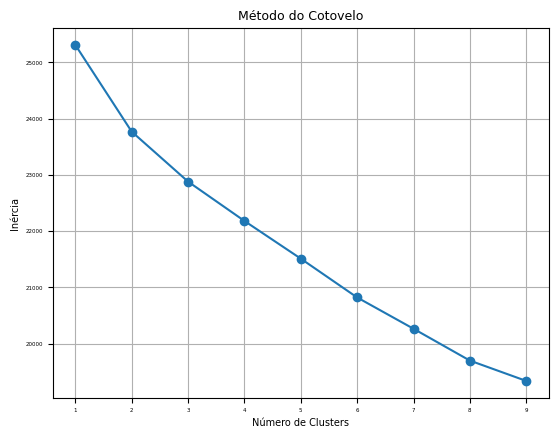

In [230]:
# Avaliação da quantidade ideal de clusters
inercia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_pca)
    inercia.append(kmeans.inertia_)

plt.plot(range(1, 10), inercia, marker='o')
plt.title('Método do Cotovelo')
plt.xlabel('Número de Clusters')
plt.ylabel('Inércia')
plt.grid(True)
plt.show()


**Estimando o número de Clusters Ideiais - silhouette score Method**

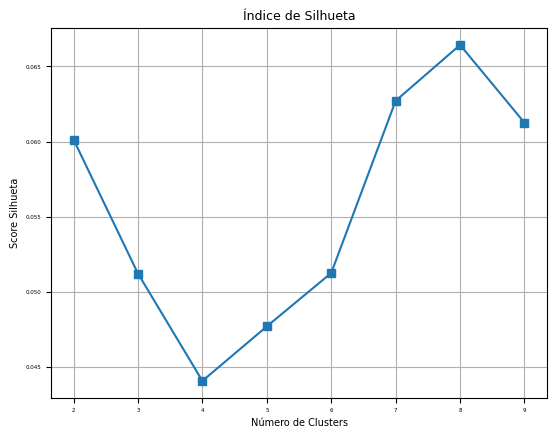

In [231]:
from sklearn.metrics import silhouette_score

scores = []
for k in range(2, 10):
    labels = KMeans(n_clusters=k, random_state=42).fit_predict(X_pca)
    score = silhouette_score(X_pca, labels)
    scores.append(score)

plt.plot(range(2, 10), scores, marker='s')
plt.title('Índice de Silhueta')
plt.xlabel('Número de Clusters')
plt.ylabel('Score Silhueta')
plt.grid(True)
plt.show()


## **Análise (n_clusters = 2)**
- Objetivo: Verificar se há perfis de alunos similares com base nas variáveis selecionadas.

In [232]:


# PCA (Análise de Componentes Principais)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)





In [233]:
# 2 Cluster
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# Visualização
df_cluster = df.copy()
df_cluster['cluster'] = clusters
df_cluster['PCA1'] = X_pca[:, 0]
df_cluster['PCA2'] = X_pca[:, 1]


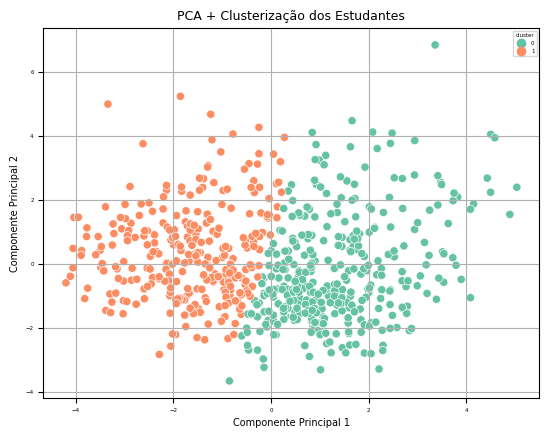

In [234]:
sns.scatterplot(data=df_cluster, x='PCA1', y='PCA2', hue='cluster', palette='Set2')
plt.title('PCA + Clusterização dos Estudantes')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True)
plt.show()

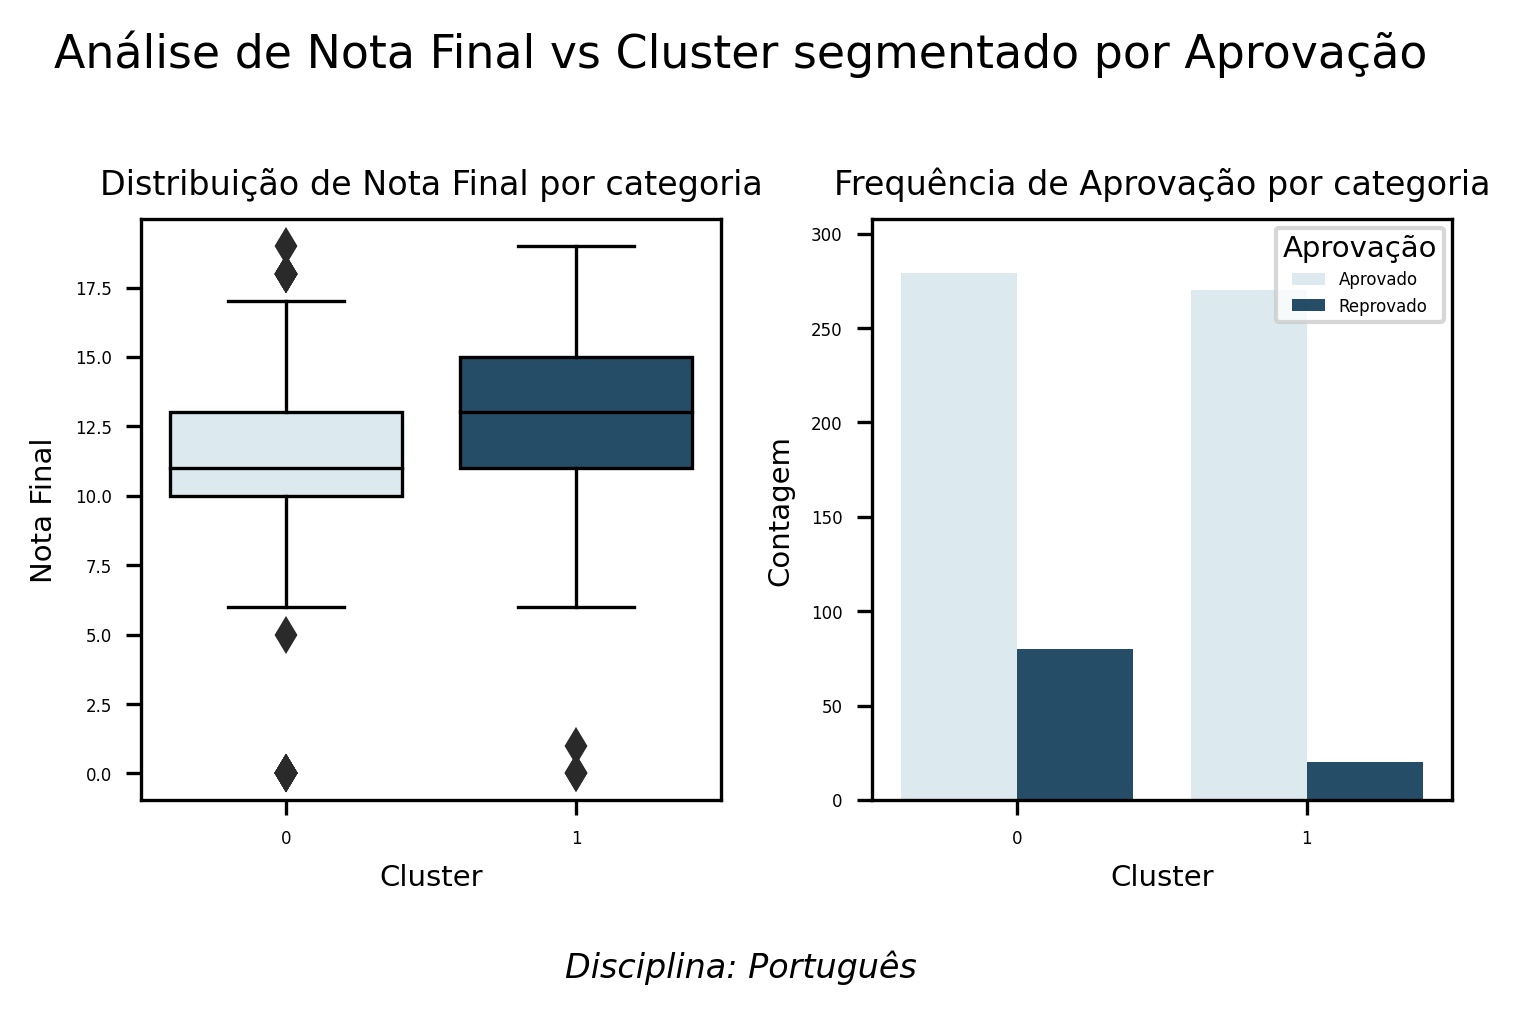

(<Figure size 1512x1008 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Distribuição de Nota Final por categoria'}, xlabel='Cluster', ylabel='Nota Final'>,
        <AxesSubplot:title={'center':'Frequência de Aprovação por categoria'}, xlabel='Cluster', ylabel='Contagem'>],
       dtype=object))

In [235]:
plot_boxplot_countplot(df_cluster,x='cluster',
                       y='nota_final',
                       materia= materia,
                       nome_arquivo='pca_cluster',
                       paleta=cor_paleta,
                       hue='aprovacao')

**Avaliando os Atributos de Maior Influência no PCA**

Metodologia - Significância estatística sob controle de covariáveis  

- Após a avaliação dos modelos, será possível investigar se os parâmetros quantitativos se mantêm ou se diferenciam.  
- Avaliação futura com PCA pode ser considerada para detectar padrões latentes nos dados.  

In [236]:
# Obtém os pesos (loadings) dos componentes principais
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'Componente {i+1}' for i in range(pca.n_components_)],
    index=X.columns
)

# Exibe os top atributos que mais influenciam o PCA
display(loadings.sort_values(by='Componente 1', key=abs, ascending=False).head(10))
display(loadings.sort_values(by='Componente 2', key=abs, ascending=False).head(10))


,Componente 1,Componente 2
escolaridade_mae,-0.400199,0.119484
escolaridade_pai,-0.371345,0.131319
profissao_mae_Professor(a),-0.241975,0.113033
escola_Mousinho da Silveira,0.241854,-0.017350
interesse_ensino_superior,-0.237381,-0.156548
tempo_transporte,0.233186,0.001420
reprovacoes,0.219468,0.158758
profissao_mae_Outra profissão,0.203141,-0.165572
endereco_Urbano,-0.197064,0.033438
idade,0.196435,0.146925


,Componente 1,Componente 2
alcool_fim_semana,0.071284,0.455627
alcool_dias_uteis,0.095720,0.427687
genero_Mulher,0.026248,-0.328229
frequencia_saidas,0.052023,0.296366
tempo_estudo,-0.135164,-0.210722
tempo_livre,0.036057,0.210030
faltas,0.053792,0.176073
profissao_mae_Outra profissão,0.203141,-0.165572
reprovacoes,0.219468,0.158758
interesse_ensino_superior,-0.237381,-0.156548


## **Análise (n_clusters = 3)**
- Objetivo: Verificar se há perfis de alunos similares com base nas variáveis selecionadas.

In [237]:


# PCA (Análise de Componentes Principais)
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)





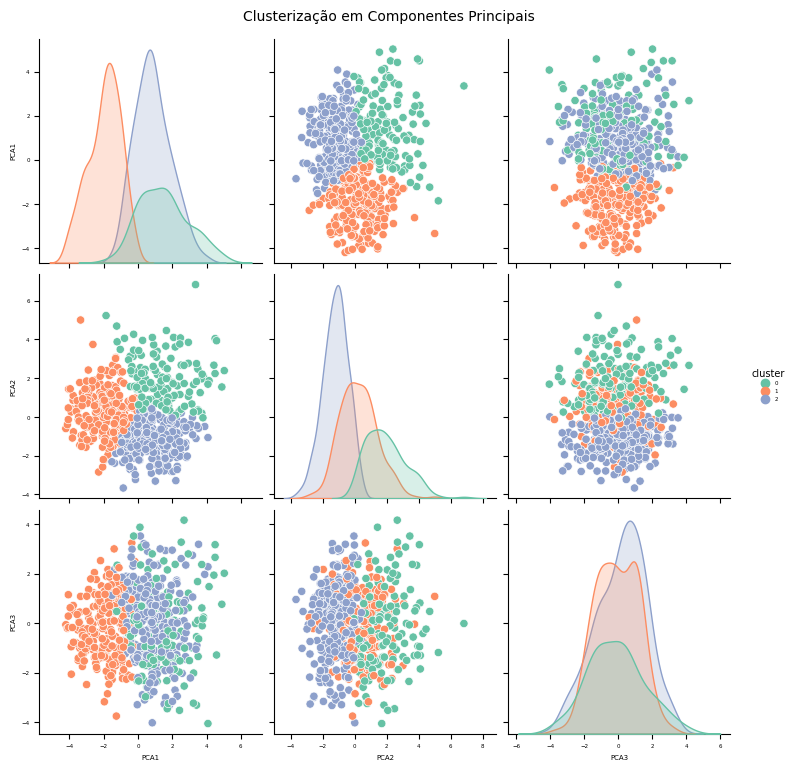

In [238]:
# 3 Cluster
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# Visualização
df_cluster = df.copy()
df_cluster['cluster'] = clusters
df_cluster['PCA1'] = X_pca[:, 0]
df_cluster['PCA2'] = X_pca[:, 1]
df_cluster['PCA3'] = X_pca[:, 2]

sns.pairplot(df_cluster, vars=['PCA1', 'PCA2', 'PCA3'], hue='cluster', palette='Set2')
plt.suptitle('Clusterização em Componentes Principais', y=1.02)
plt.show()

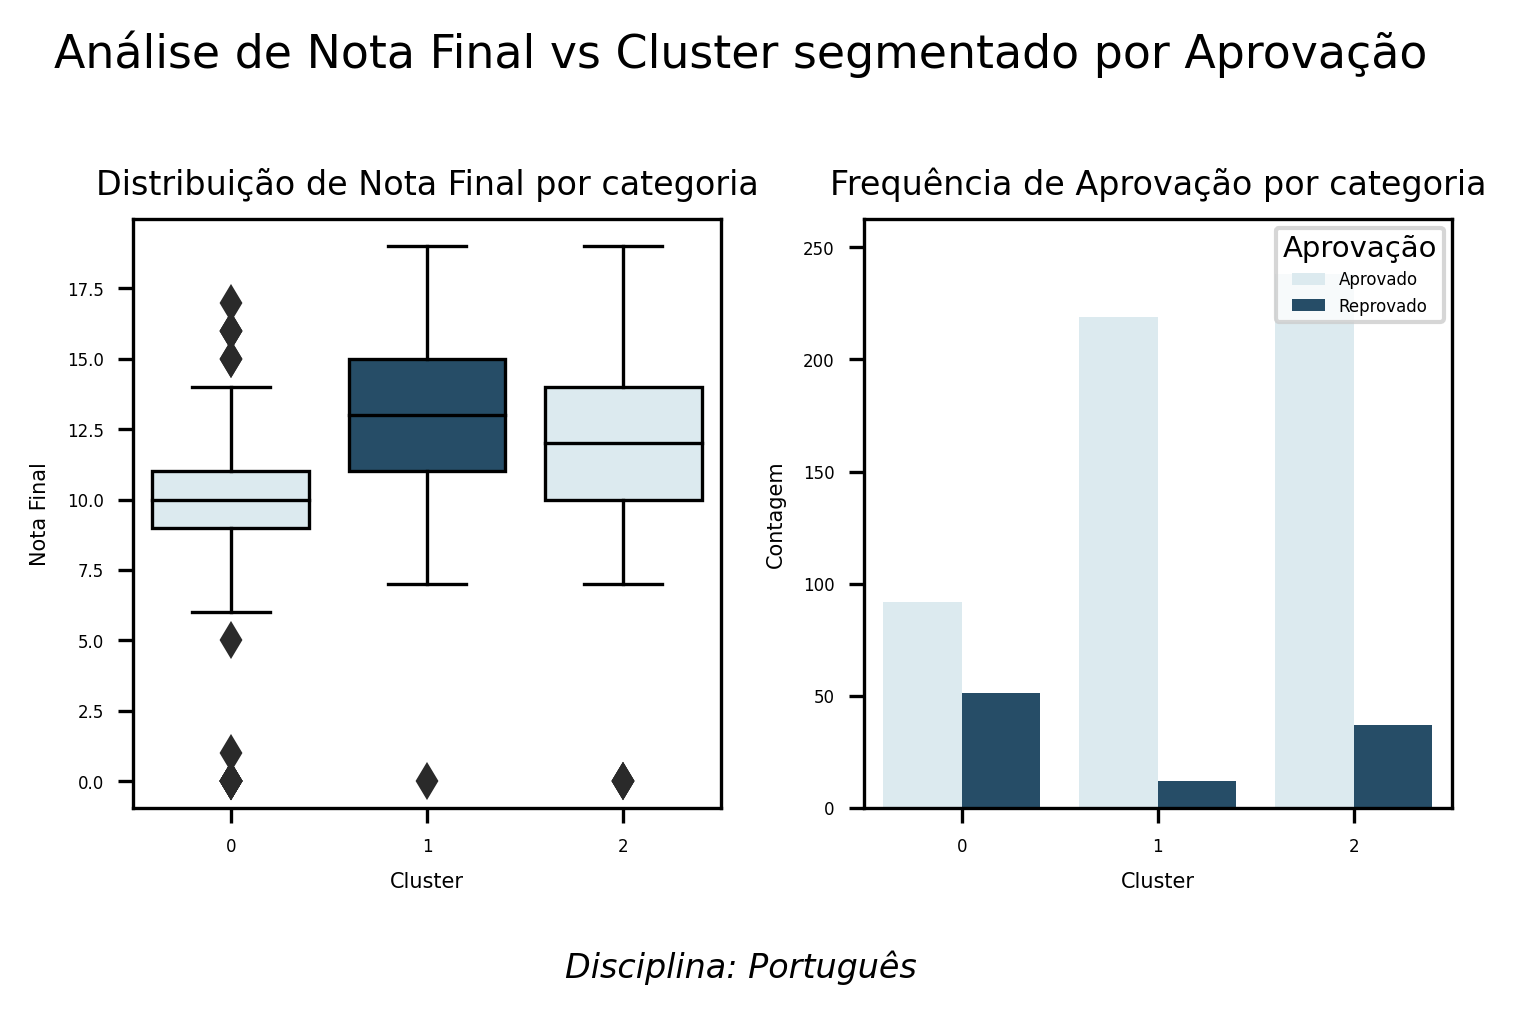

(<Figure size 1512x1008 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Distribuição de Nota Final por categoria'}, xlabel='Cluster', ylabel='Nota Final'>,
        <AxesSubplot:title={'center':'Frequência de Aprovação por categoria'}, xlabel='Cluster', ylabel='Contagem'>],
       dtype=object))

In [239]:
plot_boxplot_countplot(df_cluster,x='cluster',
                       y='nota_final',
                       materia= materia,
                       nome_arquivo='pca_cluster',
                       paleta=cor_paleta,
                       hue='aprovacao')

**Avaliando os Atributos de Maior Influência no PCA**

Metodologia - Significância estatística sob controle de covariáveis  

- Após a avaliação dos modelos, será possível investigar se os parâmetros quantitativos se mantêm ou se diferenciam.  
- Avaliação futura com PCA pode ser considerada para detectar padrões latentes nos dados.  

In [240]:
# Obtém os pesos (loadings) dos componentes principais
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'Componente {i+1}' for i in range(pca.n_components_)],
    index=X.columns
)

# Exibe os top atributos que mais influenciam o PCA
display(loadings.sort_values(by='Componente 1', key=abs, ascending=False).head(10))
display(loadings.sort_values(by='Componente 2', key=abs, ascending=False).head(10))
display(loadings.sort_values(by='Componente 3', key=abs, ascending=False).head(10))


,Componente 1,Componente 2,Componente 3
escolaridade_mae,-0.400214,0.119474,0.106790
escolaridade_pai,-0.371368,0.131303,0.032337
profissao_mae_Professor(a),-0.241949,0.112853,0.032674
escola_Mousinho da Silveira,0.241825,-0.016973,-0.325597
interesse_ensino_superior,-0.237410,-0.156380,-0.044369
tempo_transporte,0.233170,0.001501,-0.169123
reprovacoes,0.219501,0.158815,0.069429
profissao_mae_Outra profissão,0.203132,-0.165787,0.161972
endereco_Urbano,-0.197045,0.033253,0.229829
idade,0.196434,0.146883,0.179496


,Componente 1,Componente 2,Componente 3
alcool_fim_semana,0.071285,0.455863,-0.019921
alcool_dias_uteis,0.095717,0.428031,-0.013594
genero_Mulher,0.026224,-0.327750,0.022225
frequencia_saidas,0.051986,0.296709,0.060885
tempo_estudo,-0.135157,-0.210124,0.047420
tempo_livre,0.036058,0.210073,0.041488
faltas,0.053786,0.175706,0.256870
profissao_mae_Outra profissão,0.203132,-0.165787,0.161972
reprovacoes,0.219501,0.158815,0.069429
interesse_ensino_superior,-0.237410,-0.156380,-0.044369


,Componente 1,Componente 2,Componente 3
profissao_pai_Outra profissão,0.185436,-0.135592,0.400038
profissao_pai_Serviços,-0.068057,0.140194,-0.388474
escola_Mousinho da Silveira,0.241825,-0.016973,-0.325597
motivo_escolha_escola_Outro motivo,0.059494,0.068697,-0.270987
faltas,0.053786,0.175706,0.256870
responsavel_legal_Outro responsável,0.158458,0.083423,0.255099
responsavel_legal_Pai,-0.043095,-0.033217,-0.237106
endereco_Urbano,-0.197045,0.033253,0.229829
motivo_escolha_escola_Próximo de casa,-0.031414,0.015514,0.220688
status_parental_Separados,0.001211,-0.050620,0.214718
